In this notebook, we build and test the most basic approach to the Kaggle house prices challenge. Namely, we ignore categorical variables and use a standard linear regression with no regularisation. The main tool we employ to improve the model is feature engineering. We do this by including all of the numerical features in the model and then looking at the coefficients of the coefficients. This tells us which features are highly (negatively) correlated with the predictions, and also with each other. We want to avoid the latter, and so select features based on this. At the end, we also run a regressor with regularisation to see if we can't improve any further on the naive model. 

In [1]:
import numpy as np
import pandas as pd
from math import log
%matplotlib inline 
import matplotlib.pyplot as plt
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')


train_data = pd.read_csv("home-data-for-ml-course/train.csv")
test_data = pd.read_csv("home-data-for-ml-course/test.csv")

pd.set_option('display.max_columns', None)
train_data = train_data.copy()
test_data = test_data.copy()
test_data.set_index('Id', inplace = True)
train_data.set_index('Id', inplace = True);
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
train_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


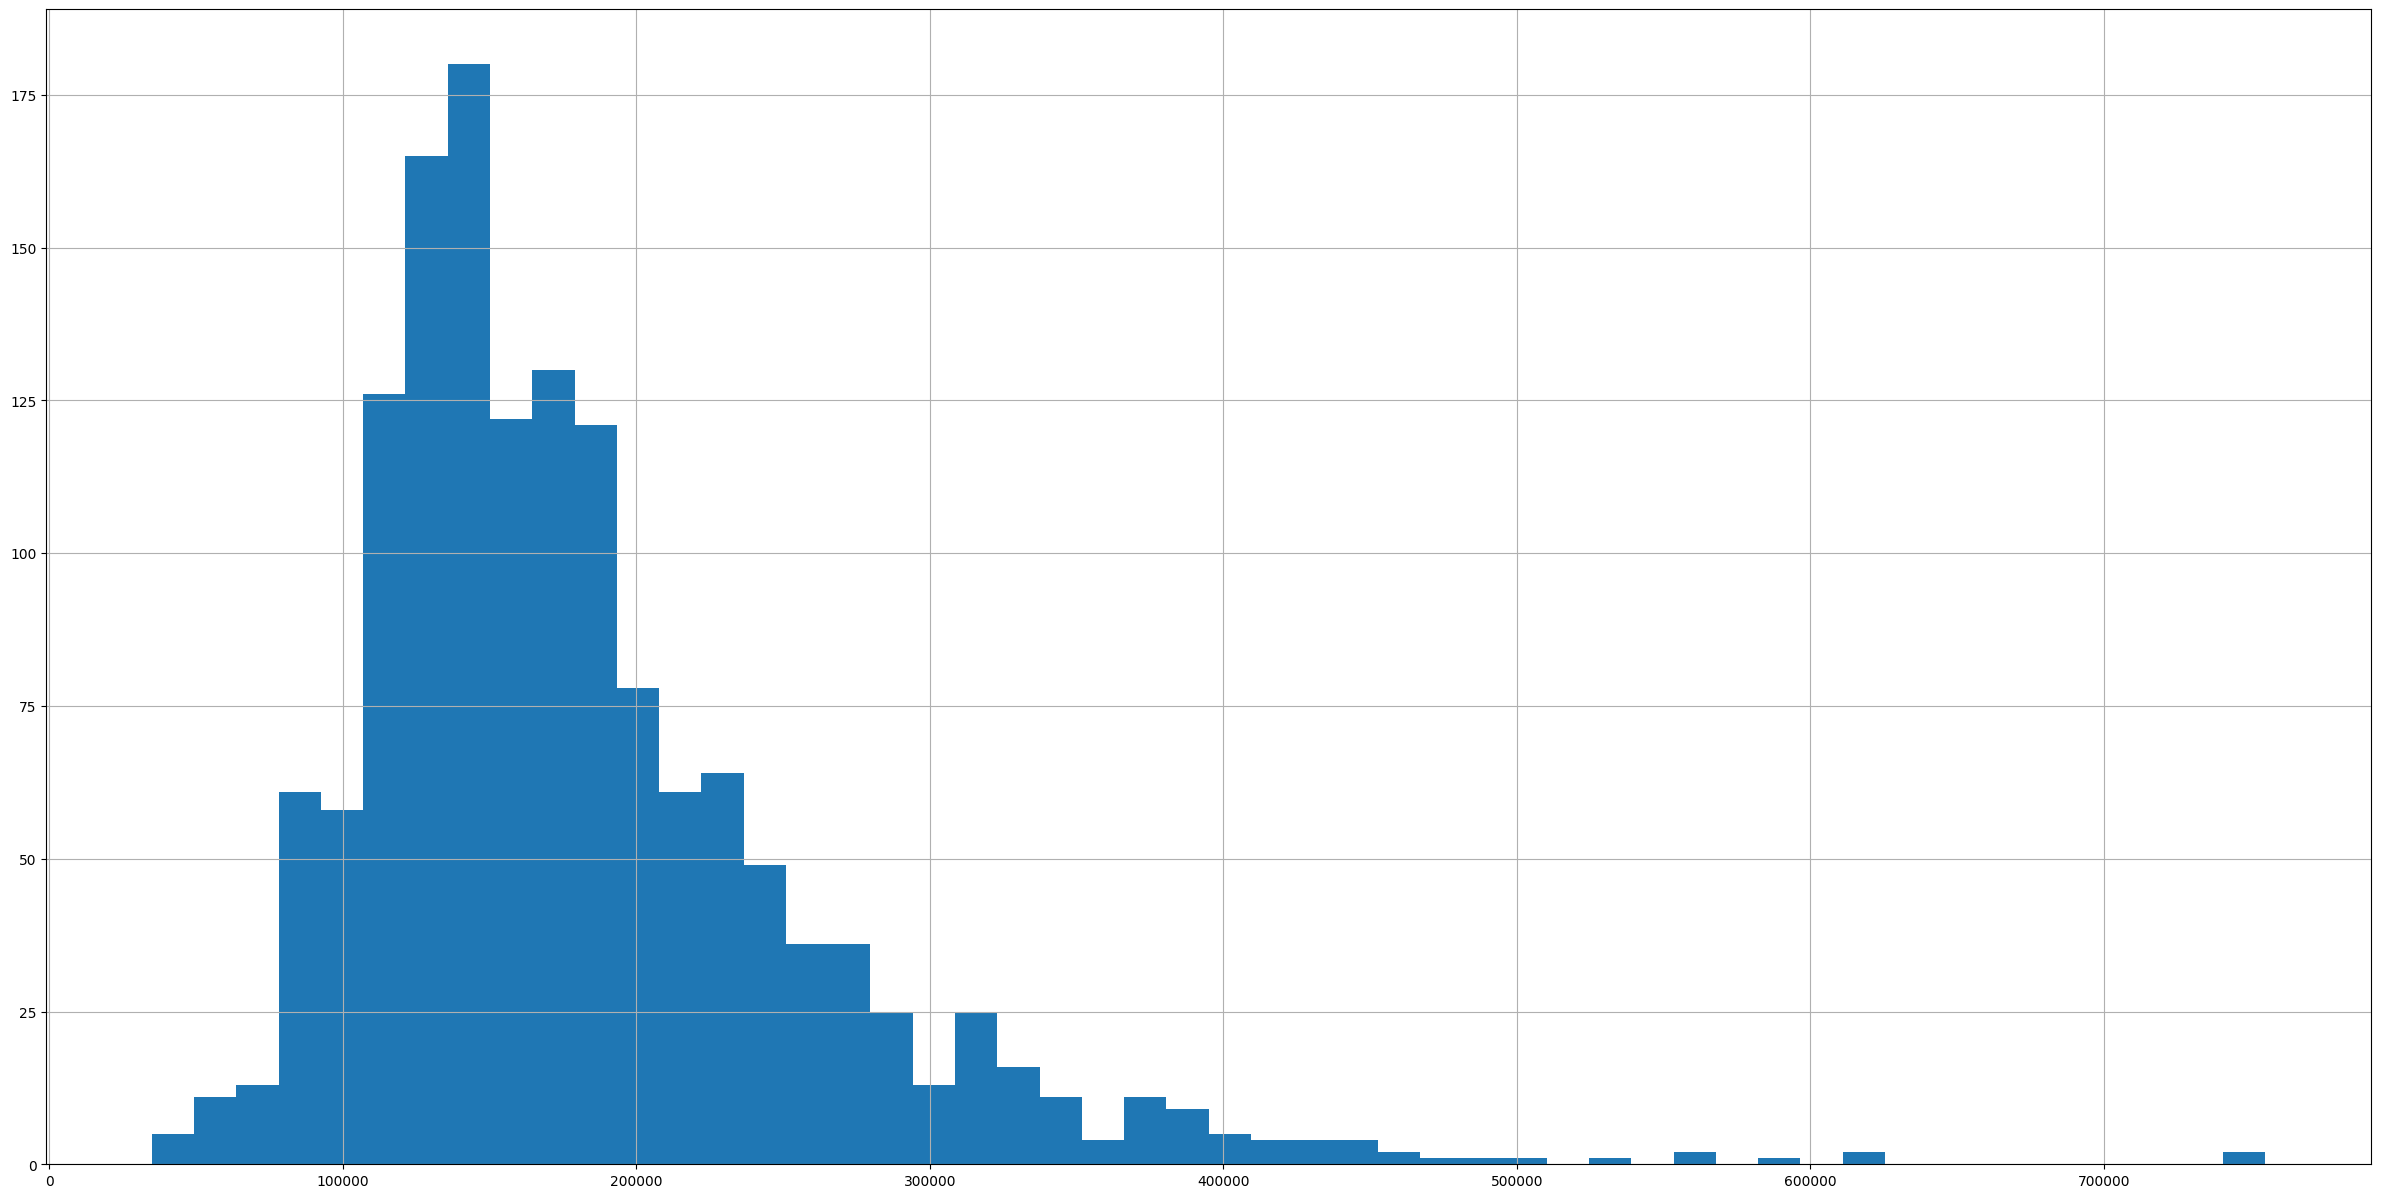

In [3]:
train_data['SalePrice'].hist(bins = 50, figsize = (30,15))
plt.show()

In [4]:
corr_matrix = train_data.corr(numeric_only = True)
corr_matrix['SalePrice'].sort_values(ascending = False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

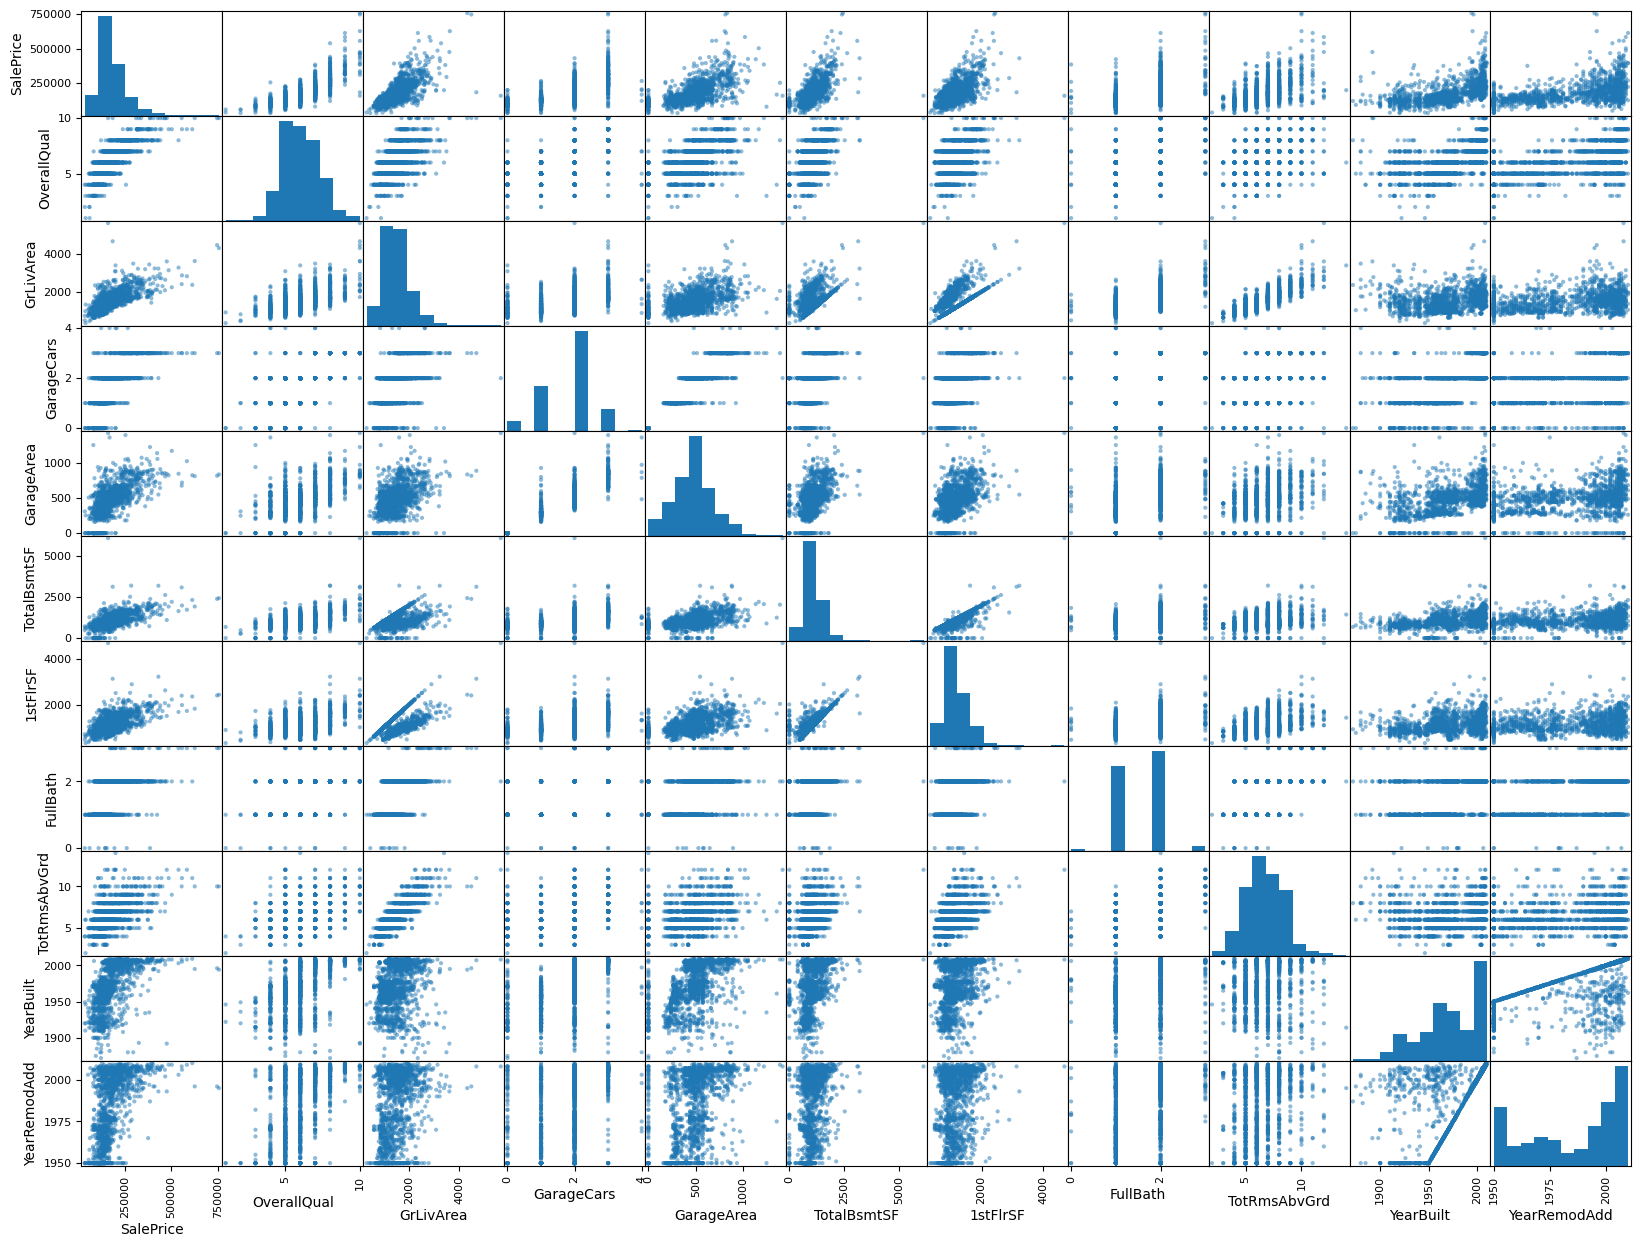

In [5]:
from pandas.plotting import scatter_matrix
highly_correlated_columns = corr_matrix['SalePrice'].sort_values(ascending = False)[0:11].axes[0].tolist()
# Pick the first 10 columns to plot against SalePrice
scatter_matrix(train_data[highly_correlated_columns], figsize = (20,15))
plt.show()

From this preliminary exploration, there a few things to note. The first is that the data is right-skewed. Therefore, in order to successfully apply a linear regression, we will need to transform the data. The natural (no pun intended) thing to do is to take the logarithm of the data, although one needs to be careful. In particular, the second point to make is that there is clearly heteroscedasticity in the relationship between sale price and some of the most strongly correlated variables. In this case, it seems that this will be the right thing to do, since it looks like the heteroscedasticity is proportional to the conditional mean. If, on the other hand, the heteroscedasticity was inversely proportional to the conditional mean, so that, for example, the variance *decreased* as the graded living area increased, then taking logarithms would exacerbate the problem. This is discussed in https://stats.stackexchange.com/questions/336315/will-log-transformation-always-mitigate-heteroskedasticity. 

Thirdly, we can see from the description that some of the scales are very different. We will therefore need to use a scaler as part of our pipeline. I will use the standard scaler since the outliers would mean that all of the other values will get squished into some really small window if we were to use a min-max scaling. 

For the next steps, we impute the missing values in the numerical data (given that this is part of a train-test-split, this will only be fit using the test data). We will train the model on all of the numerical features with the understanding that this will overfit the data. We will then look at the coefficients and decide which features to drop based on, for example, strong negative correlations between features. 

In [6]:
y = np.log(train_data.SalePrice) #Take the natural logarithm to deal with skewdness and heteroscedacity. Could probably include this 
# in a pipeline step, but it's pretty straightforward to just take the logarithm. 
train_data.drop('SalePrice', axis = 1, inplace = True)
train_data_numerical = train_data.select_dtypes(exclude = 'object')


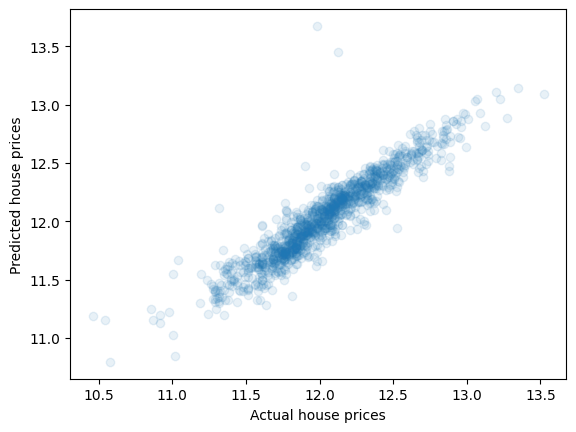

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(train_data_numerical, y, train_size = 0.8, random_state = 42)

lr_model = LinearRegression()
my_pipeline = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')), #Using median so that hopefully outliers have less of an effect.
                              ('std_scaler', StandardScaler()),
                              ('model', lr_model)
                             ])
my_pipeline.fit(X_train, y_train)
y_train_predict = my_pipeline.predict(X_train)
plt.scatter(y_train, y_train_predict, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices")
plt.show()

This looks generally in the right direction, but that is to be expected since it is almost certainly too complex and overfitting the data. 

In [8]:
RMSE_train = mean_squared_error(y_train, y_train_predict)**0.5
print(f"RMSE of the training data is: {RMSE_train}")

RMSE of the training data is: 0.14404065432115581


If we were to run the same evaluation on the testing data, we would expect to have a significantly worse result since that data is almost certainly very overfit. To confirm this, let's look at the coefficients of the regression. 

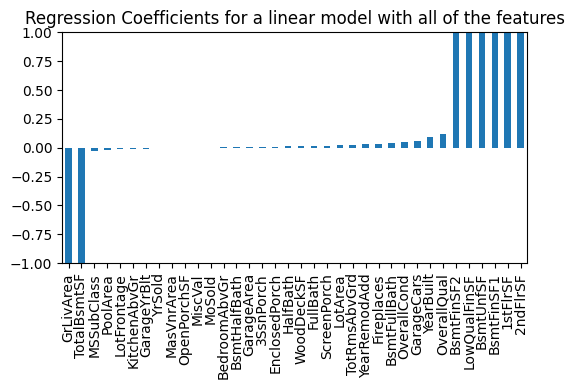

In [9]:
features = X_train.columns
coef = pd.Series(my_pipeline[2].coef_,features).sort_values()
plt.figure(figsize = (6,3))
plt.ylim(-1.0,1.0)
coef.plot(kind = 'bar', title = 'Regression Coefficients for a linear model with all of the features')
plt.show()

This is very clearly strongly overfitting the data. By printing a list of the coefficients, we can see that the order of the coefficients which go off the charts is $10^{10}$, which is comically big. I am not quite sure why graded living area should be *negatively* correlated with the other measurements of living area, but it's certainly clear that they are related to each other. Let's take GrLiving area and a few of the other features to see if we can improve our model. 

We'll drop most of the features (keeping one of them) that have huge coefficients. 

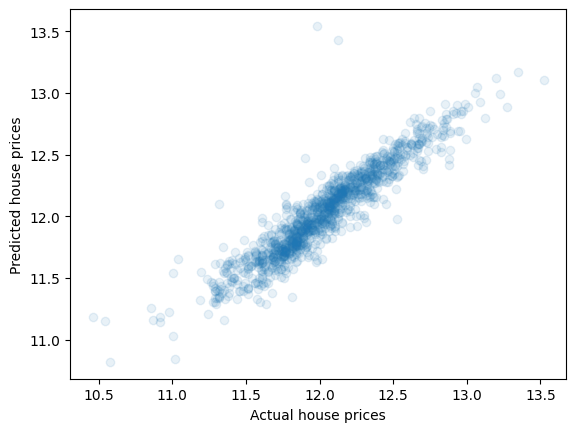

RMSE of the training data is: 0.14502270279009688


In [10]:
train_data_numerical_dropped_features = train_data_numerical.drop(['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'LowQualFinSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(train_data_numerical_dropped_features, y, train_size = 0.8, random_state = 42)

lr_model = LinearRegression()
my_pipeline = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')), #Using median so that hopefully outliers have less of an effect.
                              ('std_scaler', StandardScaler()),
                              ('model', lr_model)
                             ])
my_pipeline.fit(X_train,y_train)
y_train_predict = my_pipeline.predict(X_train)
plt.scatter(y_train, y_train_predict, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices")
plt.show()
RMSE_train = mean_squared_error(y_train, y_train_predict)**0.5
print(f"RMSE of the training data is: {RMSE_train}")

This is almost certainly an improvement. The RMSE of the model is roughly the same as what it was without any feature engineering, so I expect that we have effectively simplified the model.

RMSE of the training data is: 0.14502270279009688


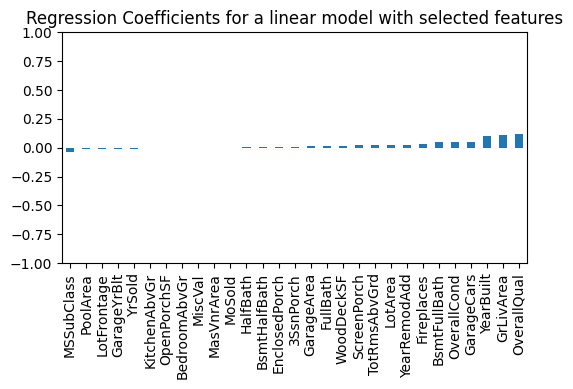

In [11]:
RMSE_train = mean_squared_error(y_train, y_train_predict)**0.5
print(f"RMSE of the training data is: {RMSE_train}")
features = X_train.columns
coef = pd.Series(my_pipeline[2].coef_, features).sort_values()
plt.figure(figsize = (6, 3))
plt.ylim(-1.0, 1.0)
coef.plot(kind = 'bar', title = 'Regression Coefficients for a linear model with selected features')
plt.show()

This is looking better, but it's still probably overfit. Let's test the model to confirm. 

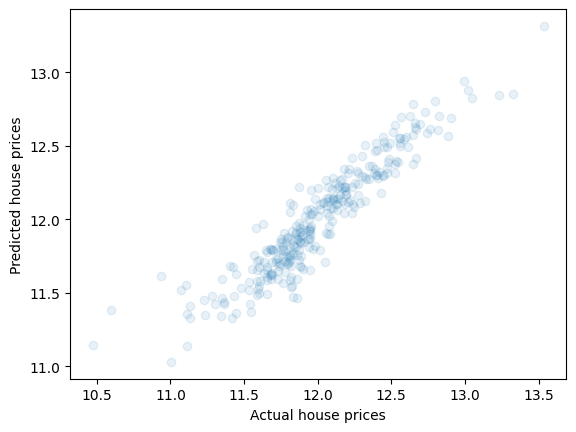

RMSE of the test data is: 0.15574891196329677


In [12]:
y_test_predict = my_pipeline.predict(X_test)
plt.scatter(y_test, y_test_predict, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices")
plt.show()
RMSE_test = mean_squared_error(y_test, y_test_predict)**0.5
print(f"RMSE of the test data is: {RMSE_test}")

So yes, this model is still overfit. We could simplify the model further by selecting several features, rather than dropping several features. We could also otpimise this by doing regularisation. 

In [13]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

model = ElasticNet()
X_train, X_test, y_train, y_test = train_test_split(train_data_numerical_dropped_features, y, train_size = 0.8, random_state = 42)
my_pipeline = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')), #Using median so that hopefully outliers have less of an effect.
                              ('std_scaler', StandardScaler()),
                              ('model', model)
                             ])
parameters = {'model__l1_ratio' : np.linspace(0,1,10), 'model__alpha' : np.logspace(-2,0,10)}

gs = GridSearchCV(my_pipeline, param_grid = parameters, scoring = 'neg_mean_squared_error', cv = 5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('std_scaler', StandardScaler()),
                                       ('model', ElasticNet())]),
             param_grid={'model__alpha': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ]),
                         'model__l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])},
             scoring='neg_mean_squared_error')

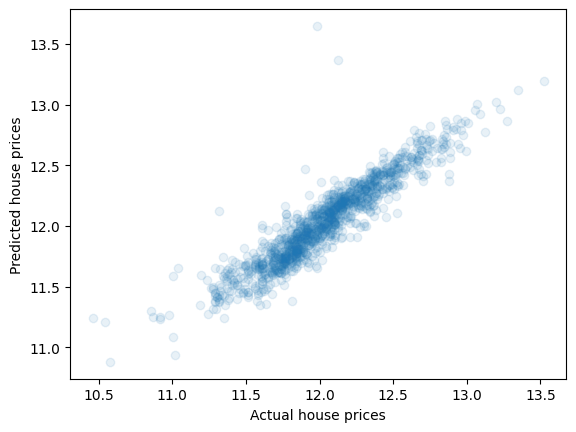

RMSE of the training data is: 0.1475149724882865
{'model__alpha': 0.027825594022071243, 'model__l1_ratio': 0.2222222222222222}


In [17]:
best_model = gs.best_estimator_
y_train_predict = best_model.predict(X_train)
plt.scatter(y_train, y_train_predict, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices")
plt.show()
RMSE_train = mean_squared_error(y_train, y_train_predict)**0.5
print(f"RMSE of the training data is: {RMSE_train}")
print(gs.best_params_)

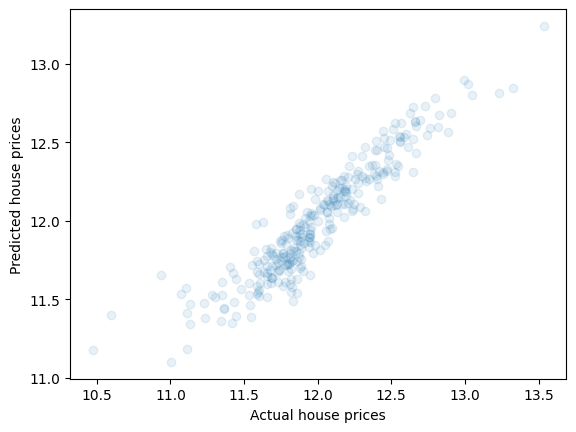

RMSE of the test data is: 0.15946657743706746


In [18]:
y_test_predict = best_model.predict(X_test)
plt.scatter(y_test, y_test_predict, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices")
plt.show()
RMSE_test = mean_squared_error(y_test, y_test_predict)**0.5
print(f"RMSE of the test data is: {RMSE_test}")

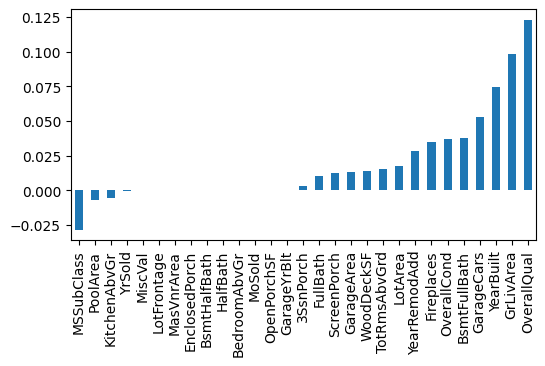

In [16]:
best_pipeline = gs.best_estimator_
best_model = best_pipeline.named_steps['model']
coef = pd.Series(best_model.coef_, index=X_train.columns).sort_values()
plt.figure(figsize=(6, 3))
coef.plot(kind='bar')
plt.show()

So this seems to not really have improved the model at all compared to not regularising. 

Overall, the model isn't good, but I believe that we have effectively improved upon the first model through feature selection and regularisation. There are certainly other things that we could do. 
* Better feature selection. We have manually done this before running a regularisation algorithm. In another notebook, we will run this regularisation algorithm on all of the data in the hope that it will select the best features to train the model on for me. It should also avoid selecting features which are highly correlated with each other (for why this is bad, see https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features).
* We have ignored categorical variables. Whilst simply adding them in through one hot or ordinal encoding would complexify the model and make overfitting worse, it's possible that there are some useful predictors in there which we might want to take in one of the features in our simplified model. In particular, the missing data should be easy to handle, since the problem tells us that missing data means that the feature doesn't exist. We can therefore use an ordinal encoder for many of the features and a one hot encoder for the rest. Adding this into a pipeline is not a major challenge.
* There seem to be some significant outliers in the data, although dealing with this properly might be tricky. Some data points are clearly outliers (for example in the plot of GrLivArea vs SalePrice), but it can be dangerous to start pruning the data too much.
* Rather than telling train_test_split to split my data, I could write a custom function to randomly split the data so that the validation data is representative of the overall data. At present, it is possible (although unlikely), that the houses in the 80th sale price percentile and above are selected as the validation data, which would mean that my model is trained without having seen any expensive houses. It is also not realistic that all unseen data corresponds to expensive houses. Whilst this is an extreme example, writing a custom function would guarantee that my train and test data are reasonably representative. 

